In [9]:
import sys
sys.path.append("../src/")

import pandas as pd
import numpy as np
from torchvision import transforms
from textDataset import *

from models import BoWClassifier, Tfid

import torch
import torch.nn as nn
import torch.optim as optim

from trainner import TrainnerNLP

from gensim.models import word2vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn import neighbors
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import time
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import multiprocessing

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

%matplotlib inline  

In [10]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [11]:
path2data = '../data/sentiment_analysis/'

text = {
        'train': TextDataset(path2data + 'train/', extension='.tsv', sep='\t', is_train = True),
}    

In [12]:
#col = 'headline_text'
#col = 'comment_text'
col = 'Phrase'
text['train'].process_data(col = col, remove_stopw = True, remove_tags=True)

In [13]:
text['train'].data.head()

,PhraseId,SentenceId,Phrase,Sentiment,subject,Phrase_data
0,1,1,A series of escapades demonstrating the adage ...,1,train,"{demonstrating, escapades, also, gander, story..."
1,2,1,A series of escapades demonstrating the adage ...,2,train,"{demonstrating, escapades, adage, series, good..."
2,3,1,A series,2,train,{series}
3,4,1,A,2,train,{}
4,5,1,series,2,train,{series}


In [14]:
sentences = { 'train': text['train'].data[col + '_data'].values}

In [15]:
hasTarget = True

if hasTarget:
    classes = ['Sentiment']
    y = np.concatenate([np.array(i) for i in text['train'].data[classes].values])
    
X = sentences['train']

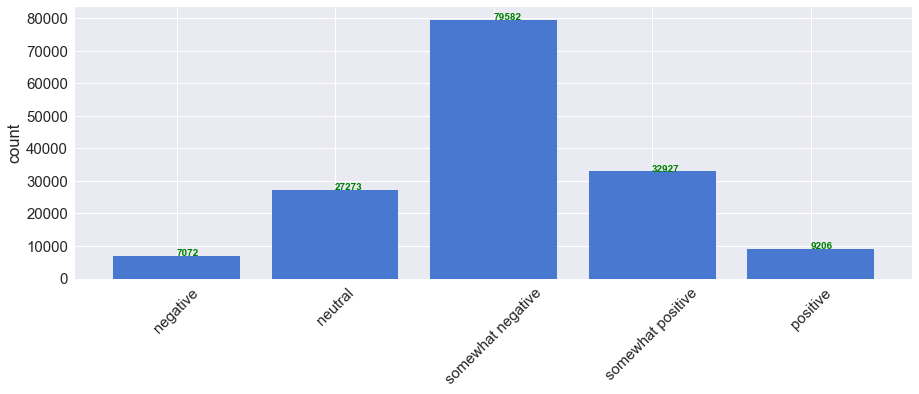

In [16]:
class_count=pd.value_counts(y, sort=False)

Index = np.arange(1,len(class_count)+1)
classes = ['negative','neutral','somewhat negative','somewhat positive','positive']
fig = plt.figure(figsize=(15,5))
plt.bar(Index,class_count,color = 'blue')
plt.xticks(Index,classes,rotation=45)
plt.ylabel('count')
plt.bar(Index, class_count)
for a,b in zip(Index, class_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')
    
fig.savefig('../figures/count_words.jpg')

### Split data in training and validation set

In [17]:
test_size = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

### Features Extraction

In [21]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 50   # Minimum word count                        
num_workers = cpu_count  # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words



W2Vmodel = word2vec.Word2Vec(workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)


W2Vmodel.build_vocab([x for x in tqdm(X_train)])
W2Vmodel.train([x for x in tqdm(X_train)], \
            total_examples=W2Vmodel.corpus_count, epochs=W2Vmodel.epochs)


100%|██████████| 124848/124848 [00:00<00:00, 2033349.25it/s]


(1386456, 2444515)

In [22]:
print ('Building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size : {}'.format(len(tfidf)))

Building tf-idf matrix ...
vocab size : 9274


In [24]:
def buildWordVector(model, tfidf, tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: 
            continue
    if count != 0:
        vec /= count
    return vec

In [27]:
f_train = np.concatenate([buildWordVector(W2Vmodel, tfidf, z, num_features) for z in map(lambda x: x, X_train)])
f_valid = np.concatenate([buildWordVector(W2Vmodel, tfidf, z, num_features) for z in map(lambda x: x, X_valid)])

/Users/renatobottermaiolopesrodrigues/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [28]:
print('Shape of train features:: {}'.format(f_train.shape))
print('Shape of valid features:: {}'.format(f_valid.shape))

Shape of train features:: (124848, 300)
Shape of valid features:: (31212, 300)


## Words visualization using PCA

In [29]:
def plot_pca(f_train, y_train, nb_clusters = 5):

    palette = np.array(sns.color_palette("hls", nb_clusters))

    pca = PCA(n_components=2)
    result = pca.fit_transform(f_train)
    
    plt.figure(figsize=(8, 8))     
    plt.scatter(result[:, 0], result[:, 1], lw=0, s=40,
                    c=palette[y_train.astype(np.int)])

    plt.title('Visualization PCA')
    plt.axis('off')
    plt.axis('tight')
    plt.show()

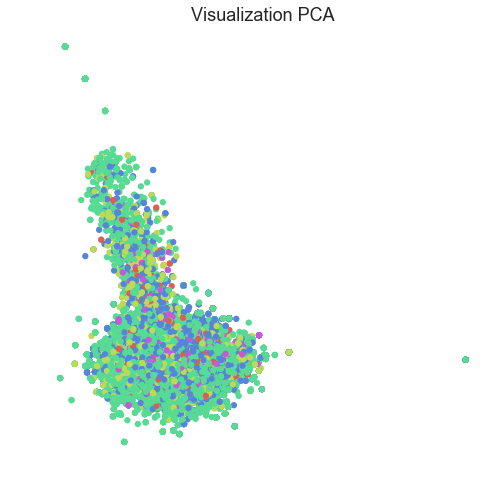

In [30]:
plot_pca(f_train, y_train)

## Words visualization using t-SNE

In [31]:
def plot_tSNE(model,n_samples = 5000):

    
    #https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm

    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title="A map of " + str(n_samples) + " word vectors",
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)


    word_vectors = [model[w] for w in model.wv.vocab.keys()][:n_samples]
    #word_vectors = [token for token in f_matrix_train][0:n_samples]

    tsne_model = TSNE(n_components=2, verbose=1, random_state=23)
    tsne_w2v = tsne_model.fit_transform(word_vectors)

    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = [k for k in model.wv.vocab.keys()][:n_samples]

    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(fig)

In [32]:
plot_tSNE(W2Vmodel)

Loading BokehJS ...

/Users/renatobottermaiolopesrodrigues/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1836 samples in 0.020s...
[t-SNE] Computed neighbors for 1836 samples in 2.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1836
[t-SNE] Computed conditional probabilities for sample 1836 / 1836
[t-SNE] Mean sigma: 0.077093
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.528702
[t-SNE] Error after 1000 iterations: 1.330418


# Unsupervised Learning approach

### Determining number of clusters - Elbow Rule
###### When K increases, the centroids are closer to the clusters centroids.

In [36]:
def elbow_rule(f_train, max_nb_cluster = 10, distortions_method='euclidean', plot=True):

    # k means determine k
    distortions = []

    for k in range(1,max_nb_cluster):
        print('Training K-means models for {} cluster/s...'.format(k))
        kmeanModel = KMeans(n_clusters=k).fit(f_train)
        kmeanModel.fit(f_train)
        if distortions_method == 'euclidean':
            distortions.append(sum(np.min(cdist(f_train, kmeanModel.cluster_centers_, 'euclidean'), \
                                          axis=1)) / f_train.shape[0])
        #elif other distortion evaluation
        
    if plot:
        # Plot the elbow
        plt.figure(figsize=(10,5))
        plt.plot(range(1,max_nb_cluster), distortions, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('Elbow Method')
        plt.show()

Training K-means models for 1 cluster/s...
Training K-means models for 2 cluster/s...
Training K-means models for 3 cluster/s...
Training K-means models for 4 cluster/s...
Training K-means models for 5 cluster/s...
Training K-means models for 6 cluster/s...
Training K-means models for 7 cluster/s...
Training K-means models for 8 cluster/s...
Training K-means models for 9 cluster/s...


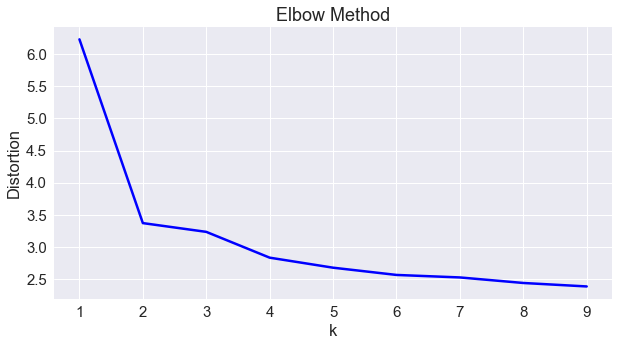

In [37]:
elbow_rule(f_train)

In [ ]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
print('Trainning K-Means...')

kmeans.fit(f_train, y_train)

score = metrics.accuracy_score(y_valid, kmeans.predict(f_valid))
print('K-Means - Accuracy on the valid set: {0:f}'.format(score))

In [ ]:
start = time.time() # Start time
idx = kmeans.predict( f_train )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering: ", elapsed, "seconds.")

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( W2Vmodel.wv.index2word, idx ))

# For the first 5 clusters
for cluster in range(0,num_clusters):
    
    print ("\nCluster %d" % cluster)
    words = []
    for key, value in word_centroid_map.items():
        if( value == cluster ):
            words.append(key)
    print (words)


# Supervised Learning approach

In [42]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.optimizers import SGD

output_dim  = nb_classes = num_clusters = 5
cmodel = Sequential() 

cmodel.add(Dense(2*num_features, input_dim=num_features, activation='relu'))
cmodel.add(Dense(output_dim, activation='softmax')) 
cmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 600)               180600    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 3005      
Total params: 183,605
Trainable params: 183,605
Non-trainable params: 0
_________________________________________________________________


In [43]:
from keras.utils import np_utils 
Y_oh_train = np_utils.to_categorical(y_train, 5)

In [44]:
cmodel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cmodel.fit(f_train, Y_oh_train, epochs=9, batch_size=32, verbose=2)

Epoch 1/9
 - 14s - loss: 1.2555 - acc: 0.5088
Epoch 2/9
 - 16s - loss: 1.2150 - acc: 0.5201
Epoch 3/9
 - 15s - loss: 1.2128 - acc: 0.5227
Epoch 4/9
 - 18s - loss: 1.2156 - acc: 0.5243
Epoch 5/9
 - 14s - loss: 1.2202 - acc: 0.5253
Epoch 6/9
 - 16s - loss: 1.2287 - acc: 0.5245
Epoch 7/9
 - 16s - loss: 1.2336 - acc: 0.5247
Epoch 8/9
 - 15s - loss: 1.2333 - acc: 0.5261
Epoch 9/9
 - 14s - loss: 1.2432 - acc: 0.5248


In [45]:
def get_acuracy(model, Xc, Y):
    Y_hat = model.predict_classes(Xc)
    accuracy = sum(Y_hat == Y)/(float(len(Y)))
    print('Accuracy: {}'.format(accuracy) )

In [72]:
get_acuracy(cmodel, f_valid, y_valid)
get_acuracy(cmodel, f_train, y_train)

Accuracy: 0.516243752402922
Accuracy: 0.5253428168653083


In [70]:
Y_hat = cmodel.predict_classes(f_train)
df_confusion = pd.crosstab(Y_hat, y_train, rownames=['Atual'], colnames=['Predicted'], normalize='index')

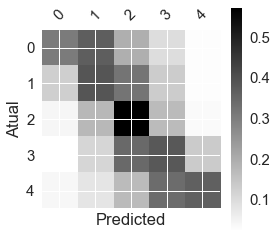

In [71]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [ ]:
plot_confusion_matrix(df_confusion)